# Passo a passo de redes neurais 

Neste notebook, iremos implementar uma rede neural de uma única camada escondida 'na mão'. 

Este notebook foi baseado no curso do Andre NG (Univ. Stanford) sobre Deep Learning, disponível no Coursera e no notebook https://github.com/Kulbear/deep-learning-coursera/blob/master/Neural%20Networks%20and%20Deep%20Learning/Planar%20data%20classification%20with%20one%20hidden%20layer.ipynb

**Funções auxiliares**: 
planar_utils.py contém funções úteis para import e visualização dos dados

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
%matplotlib inline
np.random.seed(1)

In [28]:
# Definindo algumas funções auxiliares! Não preocupe em entendê-las neste momento

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y[0], cmap=plt.cm.Spectral)
    

def sigmoid(x):
    """
    Compute the sigmoid of x
    Arguments:
    x -- A scalar or numpy array of any size.
    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

def load_extra_datasets():  
    N = 200
    noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
    noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)
    blobs = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    no_structure = np.random.rand(N, 2), np.random.rand(N, 2)
    
    return noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure

## 1 - Dataset ##

In [29]:
X, Y = load_planar_dataset()

Visualizando o dataset, que contém duas features e um output categórico. O objetivo deste exercício é criar um modelo para classificação destas categorias.

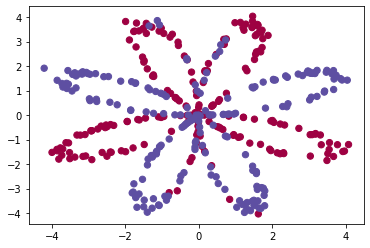

In [30]:
plt.scatter(X[0, :], X[1, :], c=Y[0], s=40, cmap=plt.cm.Spectral);

In [31]:
### Conferindo o shape
shape_X = X.shape
shape_Y = Y.shape
print(shape_X)

(2, 400)


In [32]:
print(shape_Y)

(1, 400)


## 2 - Regressão Logística

Para compararmos os resultados, utilizaremos uma regressão logistica inicialmente.

In [33]:
# Treinando regressão logística
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X.T, Y.T)

D:\Softwares\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegressionCV()

Para plotar a fronteira de decisão do problema, utilizaremos uma função que importamos das funções auxiliares, a 'plot_decision_boundary'

Text(0.5, 1.0, 'Regressão Logística')

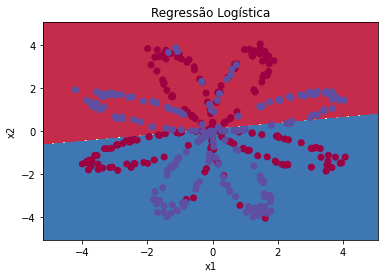

In [34]:
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Regressão Logística")

In [35]:
LR_predictions = clf.predict(X.T)
print ('Acurácia da Regressão no training set: %d ' % float((np.dot(Y, LR_predictions) + np.dot(1 - Y,1 - LR_predictions)) / float(Y.size) * 100) +
'% - lembre...nunca avalie um modelo no training set!!! :)')

Acurácia da Regressão no training set: 47 % - lembre...nunca avalie um modelo no training set!!! :)


## 3 - Modelo de Redes Neurais

Vamos tentar uma rede neural, para capturar as não linearidades do problema.

<img src="https://github.com/BernardoAflalo/FGV_NN_from_scratch/blob/master/classification_kiank.png?raw=1">


**Matematicamente**:

Para um exemplo $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1] (i)}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2] (i)}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Com as predições de todos os exemplos, podemos também calcular $J$, a função custo final:

$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$


A metodologia para construir uma rede neural é:
1. Definir a arquitetura (inputs, hidden layers)
2. Inicializar os parâmetros do modelo
3. Loop
    - Forward Propagation
    - Computar Loss e Função custo
    - BackPropagation
    - Gradiente descendente (update nos parâmetros)

### 3.1 - Arquitetura da Rede ####


- n_x: tamanho da camada de input (2)
- n_h: tamanho do hidden layer (default 4) 
- n_y: tamanho da camada de saída (1)

In [36]:
def layer_sizes(X, Y, hidden = 4):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """    
    n_x = X.shape[0] # size of input layer
    n_h = hidden
    n_y = Y.shape[0] # size of output layer
    
    return (n_x, n_h, n_y)

n_x, n_h, n_y = layer_sizes(X,Y)
print("Tamanho do Input: " + str(n_x))
print("Tamanho do Hidden: " + str(n_h))
print("Tamanho do Output: " + str(n_y))

Tamanho do Input: 2
Tamanho do Hidden: 4
Tamanho do Output: 1


### 3.2 - Inicializando os parâmetros do modelo ####

In [37]:
# initialize_parameters

def initialize_parameters(n_x, n_h, n_y):
    """
    Argumentos:
    n_x -- tamanho do input layer
    n_h -- tamanho do hidden layer
    n_y -- tamanho do output layer
    """
    
    np.random.seed(1)

    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros(shape=(n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros(shape=(n_y, 1))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [38]:
parameters = initialize_parameters(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 0.01624345 -0.00611756]
 [-0.00528172 -0.01072969]
 [ 0.00865408 -0.02301539]
 [ 0.01744812 -0.00761207]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[ 0.00319039 -0.0024937   0.01462108 -0.02060141]]
b2 = [[0.]]


### 3.3 - Forward Propagation ####

In [39]:
def forward_propagation(X, parameters):
    """
    Argumentos:
    X -- input de dados, tamanho (n_x, m). No caso, 2 por 400
    parameters -- dicionário contendo todos os parâmetros utilizados no problema
    
    Resultados:
    A2 -- output da sigmoid da segunda função de ativação - ou seja, a predição
    cache -- dicionário contendo Z1, A1, Z2 and A2. Será utilizando no back propagation
    """
    # Pegando cada parâmetro do dicionário
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # Forward Propagation para calcular A2 (estimativas)
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [40]:
A2, cache = forward_propagation(X, parameters)

Agora que temos o $A^{[2]}$, ou seja, a estimativa final, podemos calcular a função custo, da seguinte forma (log loss)


$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

### 3.4 - Função Custo ####

In [41]:
def compute_cost(A2, Y):
    """   
    
    Argumentos:
    A2 -- output da sigmoid da segunda função de ativação - ou seja, a predição (vetor de tamanho n)
    Y -- valor verdadeiro do label (vetor de tamanho n)
    parameters -- dicionário contendo W1, b1, W2 and b2
    
    Resultados:
    cost -- log loss de acordo com equação (13)
    """
    
    m = Y.shape[1] # number of example

        
    # Compute the cross-entropy cost
    logprobs = np.multiply(np.log(A2), Y) + np.multiply((1 - Y), np.log(1 - A2))
    cost = - np.sum(logprobs) / m
    
    cost = np.squeeze(cost)     # makes sure cost is the dimension we expect.                                     
    return cost

In [42]:
#A2, Y_assess, parameters = compute_cost_test_case()

print("custo = " + str(compute_cost(A2, Y)))

custo = 0.6931172505517665


### 3.5 - Backward Propagation ####

<img src="https://github.com/BernardoAflalo/FGV_NN_from_scratch/blob/master/grad_summary.png?raw=1" style="width:600px;height:300px;">

<!--
$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

- Note that $*$ denotes elementwise multiplication.
- The notation you will use is common in deep learning coding:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$
    
!-->

- Tips:
    - To compute dZ1 you'll need to compute $g^{[1]'}(Z^{[1]})$. Since $g^{[1]}(.)$ is the tanh activation function, if $a = g^{[1]}(z)$ then $g^{[1]'}(z) = 1-a^2$. So you can compute 
    $g^{[1]'}(Z^{[1]})$ using `(1 - np.power(A1, 2))`.

In [43]:
def backward_propagation(parameters, cache, X, Y):
    """    
    Argumentos:
    parameters -- dicionário com os parâmetros
    cache -- dicionário contendo "Z1", "A1", "Z2" and "A2".
    X -- input de dados, tamanho (n_x, m). No caso, 2 por 400
    Y -- valor verdadeiro do label (vetor de tamanho n)
    
    Resultado:
    grads -- dicionário contendo os gradientes dos parâmetros (Será usado no gradiente descendente)
    """
    m = X.shape[1]
    
    # Pegando W1 e W2 do dicionário de parâmetro e A1 e A2 do dicionário de cache
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    A1 = cache['A1']
    A2 = cache['A2']

    
    # Cálculo do backpropagation 
    dZ2= A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)    
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [44]:
grads = backward_propagation(parameters, cache, X, Y)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[-7.29763880e-05  6.28429223e-04]
 [ 5.63102875e-05 -4.89769961e-04]
 [-3.38878017e-04  2.84968032e-03]
 [ 4.72583147e-04 -4.05737552e-03]]
db1 = [[ 1.25563628e-07]
 [ 6.90147076e-09]
 [ 1.12853330e-06]
 [-1.03138342e-06]]
dW2 = [[-0.00157427 -0.00199041 -0.00471285 -0.00189623]]
db2 = [[-1.14159765e-06]]


O que esses valores representam? É como a função custo varia com a variação de cada parâmetro. Valores negativos indicam que, ao aumentar o valor do parâmetro w ou b, diminuimos a função custo final. De maneira análoga, um valor positivo signifca que diminuindo o valor do parâmetro, diminuimos a função custo! Essa é a matéria prima para o gradiente descendente: como a função custo varia com cada parâmetro.

Como exemplo, considere o primeiro valor de dW1, que representa o gradiente do peso do primeiro neurônio de input com o primeiro neurônio da camada escondida. O valor negativo indica que, ao aumentar o peso, diminuimos a função custo. Vamos ver se isso é verdade:

In [45]:
print("Peso antes: " + str(parameters['W1'][1][1]))
A2, cache = forward_propagation(X, parameters)
print("Custo antes = " + str(compute_cost(A2, Y)))

# Adicionando um pequeno valor positivo ao primeiro peso
parameters['W1'][1][1] = parameters['W1'][1][1] + 0.01

A2, cache = forward_propagation(X, parameters)
print("Peso depois: " + str(parameters['W1'][1][1]))
print("Custo depois = " + str(compute_cost(A2, Y)))

Peso antes: -0.010729686221561705
Custo antes = 0.6931172505517665
Peso depois: -0.000729686221561705
Custo depois = 0.6931123462350075


### 3.6 - Gradiente Descendente ####

**Gradiente Descendente**: $ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ em que $\alpha$ é o learning rate e $\theta$ são os parâmetros.

**Ilustração**: Gradiente descendente com learning rate bom e ruim. Cortesia de Adam Harley.

<img src="https://github.com/BernardoAflalo/FGV_NN_from_scratch/blob/master/sgd.gif?raw=1" style="width:400;height:400;"> <img src="https://github.com/BernardoAflalo/FGV_NN_from_scratch/blob/master/sgd_bad.gif?raw=1" style="width:400;height:400;">



In [46]:
def update_parameters(parameters, grads, learning_rate=1.2):
    """
    Atualiza os parâmetros utilizando gradiente descendente
    
    Argumentos:
    parameters -- dicionário com os parâmetros 
    grads -- dicionário contendo os gradientes dos parâmetros
    
    Resultados:
    parameters -- dicionário python com os parâmetros atualizados
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # Retrieve each gradient from the dictionary "grads"
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    
    # Update rule for each parameter    
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [47]:
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 0.01633103 -0.00687168]
 [-0.00534929 -0.00014196]
 [ 0.00906073 -0.026435  ]
 [ 0.01688102 -0.00274322]]
b1 = [[-1.50676354e-07]
 [-8.28176491e-09]
 [-1.35423995e-06]
 [ 1.23766010e-06]]
W2 = [[ 0.00507952 -0.00010522  0.0202765  -0.01832593]]
b2 = [[1.36991719e-06]]


### 4.4 - Criando sua própria rede neural

In [48]:
def nn_model(X, Y, n_h, epochs=1000, batch_size = 100, print_cost=False):
    import pandas as pd
    """
    Arguments:
    X -- input dos dados
    Y -- labels
    n_h -- tamanho da hidden layer
    epochs -- número de épocas
    batch_size -- tamanho do batch
    print_cost -- se True, mostra o custo a cada 1000 iterações
    
    Resultados:
    parameters -- parâmetros aprendidos pelo modelo. Podem ser utilizados para fazer 'predict'
    """
    batches_init = pd.Series(range(0, X.shape[1], batch_size))
    batches_end = batches_init-1
    batches_end = pd.concat([batches_end[1:], pd.Series(X.shape[1])-1], ignore_index = True)


    np.random.seed(1)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]

    # Inicializando parâmetros
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']  

    # loop nas épocas
    for i in range(0, epochs):

        # Loop nos batches
        for id_batch in range(0,len(batches_init)):        
            X_batch = X[:,batches_init[id_batch]:batches_end[id_batch]]    
            Y_batch = Y[:,batches_init[id_batch]:batches_end[id_batch]]    

            # Forward propagation.
            A2, cache = forward_propagation(X_batch, parameters)

            # Cost function.
            cost = compute_cost(A2, Y_batch)        

            # Backpropagation.
            grads = backward_propagation(parameters, cache, X_batch, Y_batch)    

            # Gradient descent. Atualiza os parâmetros
            parameters = update_parameters(parameters, grads, learning_rate=0.1)

            # Print do erro
            if print_cost and i % 1000 == 0:
                print('.' ,end =" ")
                if id_batch == len(batches_init)-1:
                    print ("Custo depois da época %i: %f" % (i, cost))
            
            
        

    return parameters

In [49]:
parameters = nn_model(X, Y, 4, epochs=10000, batch_size = 100, print_cost=True)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

. . . . Custo depois da época 0: 0.716484
. . . . Custo depois da época 1000: 0.296247
. . . . Custo depois da época 2000: 0.267924
. . . . Custo depois da época 3000: 0.254892
. . . . Custo depois da época 4000: 0.247013
. . . . Custo depois da época 5000: 0.241460
. . . . Custo depois da época 6000: 0.237254
. . . . Custo depois da época 7000: 0.233951
. . . . Custo depois da época 8000: 0.231291
. . . . Custo depois da época 9000: 0.229105
W1 = [[ 0.03918528  6.66814472]
 [-0.33303435 -1.46315226]
 [ 7.38187613 -9.37774764]
 [ 6.7368256   7.87815697]]
b1 = [[ 0.10100857]
 [-2.90735543]
 [ 0.09853611]
 [ 0.09875392]]
W2 = [[ 8.10228739  0.81938849  4.78290233 -4.77937322]]
b2 = [[0.41484669]]


### 4.5 Predição


**Função 'predict'**: $y_{prediction} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  


In [50]:
def predict(parameters, X):
    """
    Função de 'predict'. Usa apenas o forward propagation!
    
    Arguments:
    parametros -- dicionario contendo os parâmetros do modelo
    X -- data set de input
    
    Returnos
    predições -- vetor de predições do modelo (0/1)
    """

    A2, cache = forward_propagation(X, parameters)
    predictions = np.round(A2)
    
    return predictions

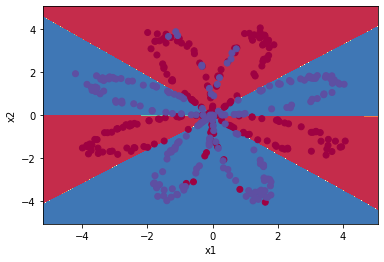

In [51]:
# Plota a fronteira de decisão
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)

In [52]:
predictions = predict(parameters, X)
print ('Acurácia: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')

Acurácia: 90%
